In [1]:
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time
import zipfile
from IPython import display
import os
import cv2
from matplotlib import image
from skimage.color import rgb2gray

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#### HYPER PARAMETERS
BATCH_SIZE = 50
EPOCHS = 1000
noise_dim = 100
BUFFER_SIZE = 60000
WIDTH=128
HEIGHT=128

seed = tf.random.normal([1, noise_dim])

In [4]:
image_dir = "YourPath"
filepath = "YourPath"
os.system("mkdir -p "+filepath+"/Saved_Models")
save_destination =filepath + "/Saved_Models"

In [5]:
os.chdir(image_dir)
path = "*.*"
data = []
for file in glob.glob(path):
  if(file.find("image_at_epoch") == -1):
    img_data = image.imread(file, 0)
    data.append(img_data)
data = np.array(data)

In [6]:
# Assuming WIDTH and HEIGHT are defined somewhere in your code
# Assuming data is your original numpy array

standardized_data = []
for img in data:
    if len(img.shape) == 3:  # Check if the image has 3 channels (RGB)
        img_gray = rgb2gray(img)
    else:
        img_gray = img  # Assuming the image is already grayscale
    standardized_data.append(cv2.resize(img_gray, (WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC).astype('float32'))

train_images = np.array(standardized_data)
train_images = train_images.reshape(train_images.shape[0], WIDTH, HEIGHT, 1).astype('float32')
print(train_images.shape)


(4406, 128, 128, 1)


In [7]:
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
checker = train_images # np.reshape(train_images, (4396,128,128))
#plt.imshow(checker[5,:,:,0])


In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 1024)))
    assert model.output_shape == (None, 4, 4, 1024) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 1)

    model.add(layers.Flatten())
    model.add(layers.Dense(128*128, use_bias=False, activation = 'tanh'))
    model.add(layers.Reshape((128,128,1)))
    print(model.output_shape)

    return model

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 1]))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 4, 4, 1024)
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64))
    model.add(layers.Dense(32))
    model.add(layers.Dense(16))
    model.add(layers.Dense(1, activation="sigmoid"))

    opt = tf.keras.optimizers.Adam(1e-4)

    model.compile(loss = 'binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [10]:
def make_gan(g_model, d_model):

  d_model.trainable = False
  model = tf.keras.Sequential()
  model.add(g_model)
  model.add(d_model)

  opt = tf.keras.optimizers.Adam(1e-4)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [11]:
def generate_real_samples(dataset, n_samples):

  ix = np.random.randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = np.ones((n_samples, 1))
  return X,y

In [12]:
def generate_latent_points(latent_dim, n_samples):

  x_input = np.random.randn(latent_dim*n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [13]:
def generate_fake_samples(g_model, latent_dim, n_samples):

  x_input = generate_latent_points(latent_dim, n_samples)
  X = g_model.predict(x_input)
  y = np.zeros((n_samples, 1))
  return X,y

In [14]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, batch_size):

  genLoss = 0
  discLoss = 0
  batch_per_epoch = int(dataset.shape[0]/batch_size)
  half_batch = int(batch_size/2)
  best_g_model = g_model
  best_genLoss = 10
  for epoch in range(n_epochs):
    start = time.time()
    for i in range(batch_per_epoch):
      X_real, y_real = generate_real_samples(dataset,half_batch)
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)

      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)

      discLoss = (d_loss1 + d_loss2)/2

      X_gan = generate_latent_points(latent_dim, batch_size)
      y_gan = np.ones((batch_size, 1))
      genLoss = gan_model.train_on_batch(X_gan, y_gan)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(g_model,
                            epoch + 1,
                            seed)

    ### PERFORMANCE CHECK
    X_real, y_real = generate_real_samples(dataset, 100)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, 100)
    _, acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)
    print("Disc Accuracy Real: %.5f, fake: %.5f" % (acc_real, acc_fake))
    print("genloss: {} discloss: {}".format(genLoss, discLoss))
    if (epoch > 2./3. * n_epochs):
      if (genLoss < best_genLoss and acc_real > 0.9 and acc_fake > 0.9):
        best_genLoss = genLoss
        best_g_model = g_model

    # Save the model every 100 epochs
    if epoch%100 == 0:
      g_model.save(save_destination+"/generator_intermediate.h5")
      d_model.save(save_destination+"/discriminator_intermediate.h5")

    genloss.append(genLoss)
    discloss.append(discLoss)
    accReal.append(acc_real)
    accFake.append(acc_fake)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(g_model,
                          n_epochs,
                          seed)
  print("Training complete")
  return best_g_model

In [15]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.show()

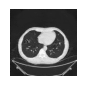

Training complete


In [16]:
genloss = []
discloss = []
accReal = []
accFake = []
d_model = make_discriminator_model()
g_model = make_generator_model()
gan_model = make_gan(g_model, d_model)
generator = train(g_model, d_model, gan_model, train_images, noise_dim, EPOCHS, BATCH_SIZE)

g_model.save(save_destination+"/generator_final.h5")
d_model.save(save_destination+"/discriminator_final.h5")
gan_model.save(save_destination+"/gan_final.h5")

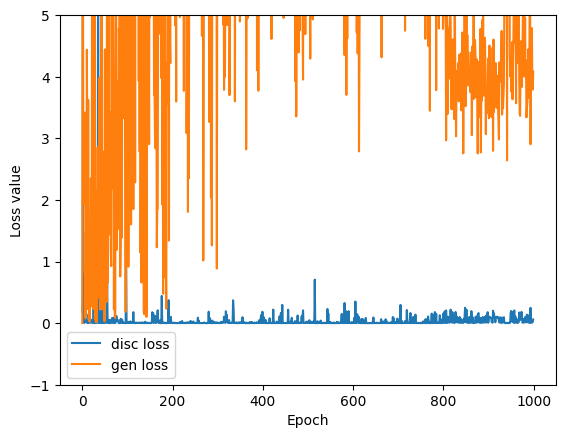

In [17]:
plt.plot(range(EPOCHS), discloss, label='disc loss')
plt.plot(range(EPOCHS), genloss, label='gen loss')
plt.xlabel('Epoch')
plt.ylim(-1,5)
plt.ylabel('Loss value')
plt.legend()
plt.show()

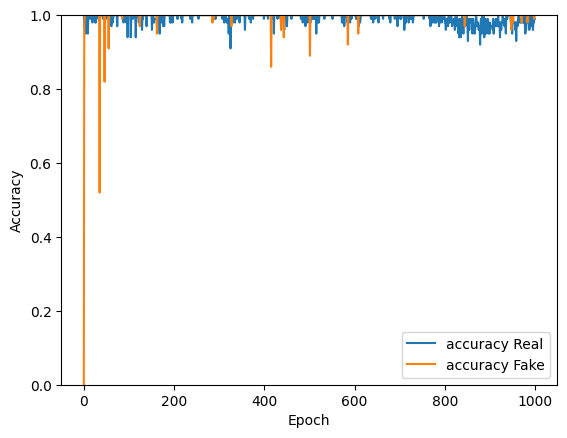

In [18]:
plt.plot(range(EPOCHS), accReal, label='accuracy Real')
plt.plot(range(EPOCHS), accFake, label='accuracy Fake')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 24ms/step


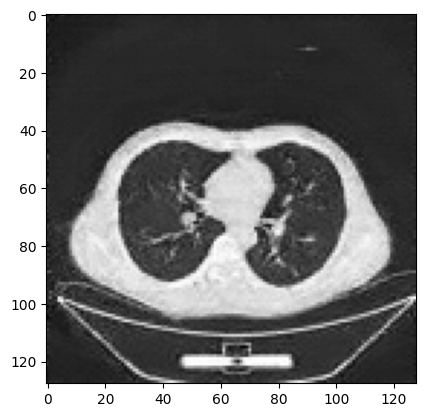

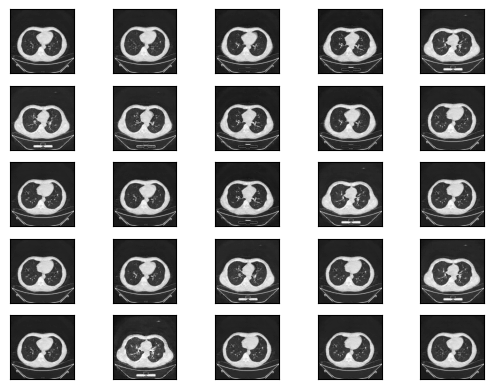

In [19]:
plt.figure()
noise = np.random.randn(noise_dim)
noise = noise.reshape(1, noise_dim)
generated_image0 = generator.predict(noise)
plt.imshow(generated_image0[0, :, :, 0], cmap='gray')

f = plt.figure()
for i in range(1,26):
  f.add_subplot(5,5, i)
  noise = np.random.randn(noise_dim)
  noise = noise.reshape(1, noise_dim)
  generated_image0 = generator.predict(noise)
  plt.imshow(generated_image0[0, :, :, 0], cmap='gray')
  plt.xticks([])
  plt.yticks([])
plt.show()

In [20]:
# Assuming you have defined noise_dim and generator before this code snippet

filepath_generate_image = "YourPath"

plt.figure()
noise = np.random.randn(noise_dim)
noise = noise.reshape(1, noise_dim)
generated_image0 = generator.predict(noise)
plt.imshow(generated_image0[0, :, :, 0], cmap='gray')
plt.savefig(filepath_generate_image + '/fake_image_0.png')  # Save the generated image
plt.close()  # Close the current figure to avoid overlap with the next one

f = plt.figure()
for i in range(1, 26):
    f.add_subplot(5, 5, i)
    noise = np.random.randn(noise_dim)
    noise = noise.reshape(1, noise_dim)
    generated_image = generator.predict(noise)
    plt.imshow(generated_image[0, :, :, 0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.savefig(filepath_generate_image + f'/fake_image_{i}.png')  # Save the generated image
    plt.close()  # Close the current figure to avoid overlap with the next one
plt.show()

1/1 [==============================] - 0s 26ms/step
